In [1]:
!pip install adversarial-robustness-toolbox

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

import numpy as np
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
BATCH_SIZE = 128

# CIFAR-10 preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Loading CIFAR-10 Datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# separate test_loader later for generating attacks on the test set
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("CIFAR-10 datasets loaded.")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

CIFAR-10 datasets loaded.
Training set size: 50000
Test set size: 10000


In [ ]:
# Defining the Baseline Model (ResNet-18)

# Loading ResNet-18
baseline_model = models.resnet18(weights=None)

# Adapting ResNet-18 for CIFAR-10 (32x32 images)

# Adjusting first layer for smaller input size
baseline_model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
# Remove initial max pooling layer
baseline_model.maxpool = nn.Identity()

# Adapt final layer for 10 CIFAR classes
num_ftrs = baseline_model.fc.in_features # Get input features to last layer
baseline_model.fc = nn.Linear(num_ftrs, 10)

baseline_model = baseline_model.to(device)

print("ResNet-18 model defined and moved to device.")
print(baseline_model)

ResNet-18 model defined and moved to device.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d

In [5]:
EPOCHS_TEMP_BASELINE = 25
LEARNING_RATE = 0.001

In [6]:
# Training Function
def train_model(model, train_loader, optimizer, loss_fn, epochs, description, scheduler=None):
    model.train() # Set the model to training mode
    print(f"Starting {description} training...")

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        correct_predictions = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad() # Reset gradients from previous step
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct_predictions += (predicted == target).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = (correct_predictions / len(train_loader.dataset)) * 100
        print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        if scheduler:
            scheduler.step()

    print(f"{description} training completed.")

In [7]:
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(baseline_optimizer, step_size=20, gamma=0.1)

loss = nn.CrossEntropyLoss()

# print("--- Training Temporary Baseline ResNet Model ---")
# train_model(
#     model=baseline_model,
#     train_loader=train_loader,
#     optimizer=baseline_optimizer,
#     loss_fn=loss,
#     epochs=EPOCHS_TEMP_BASELINE,
#     description="Temporary CIFAR-10 Baseline",
#     scheduler=scheduler
# )
# print("--- Baseline Training Finished ---")


import os

model_save_dir = 'models'
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, "temp_baseline_resnet_cifar.pth")

torch.save(baseline_model.state_dict(), model_save_path)

print(f"Temporary CIFAR-10 ResNet Baseline model saved to Kaggle at: {model_save_path}")


Temporary CIFAR-10 ResNet Baseline model saved to Kaggle at: models/temp_baseline_resnet_cifar.pth


In [8]:
# Reloading the baseline model for attack generation

# New instance of model 
baseline_model_for_attack = models.resnet18(weights=None)
baseline_model_for_attack.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
baseline_model_for_attack.maxpool = nn.Identity()
num_ftrs = baseline_model_for_attack.fc.in_features
baseline_model_for_attack.fc = nn.Linear(num_ftrs, 10)

# 2. Loading the saved weights
model_load_path = "/kaggle/input/baseline-model/pytorch/default/1/temp_baseline_resnet_cifar.pth"
baseline_model_for_attack.load_state_dict(torch.load(model_load_path))

baseline_model_for_attack = baseline_model_for_attack.to(device)
baseline_model_for_attack.eval()

print(f"Temporary baseline model loaded from {model_load_path} and set to eval mode.")

Temporary baseline model loaded from /kaggle/input/baseline-model/pytorch/default/1/temp_baseline_resnet_cifar.pth and set to eval mode.


In [9]:
ATTACK_EPSILON = 8/255  # Standard epsilon for CIFAR-10 PGD
ATTACK_MAX_ITER = 10    # Number of PGD steps
ATTACK_EPS_STEP = 2/255 # Step size for each PGD iteration


art_classifier = PyTorchClassifier(
    model=baseline_model_for_attack,
    loss=nn.CrossEntropyLoss(),
    optimizer=None, 
    input_shape=(3, 32, 32), # CIFAR-10 shape
    nb_classes=10,
    device_type=device.type 
)

# Instance of the PGD attack
pgd_attack = ProjectedGradientDescent(
    art_classifier,
    eps=ATTACK_EPSILON,
    eps_step=ATTACK_EPS_STEP,
    max_iter=ATTACK_MAX_ITER,
    batch_size=BATCH_SIZE
)

print("ART classifier wrapper and PGD attack configured.")

ART classifier wrapper and PGD attack configured.


In [10]:
# # Preparing test data
# test_images_numpy = test_dataset.data.transpose(0, 3, 1, 2).astype(np.float32) / 255.0 # Transpose AND normalize to [0,1]
# test_labels_numpy = np.array(test_dataset.targets)

# print("Preparing to generate adversarial examples...")

# # Generating adversarial images
# adversarial_images_np = pgd_attack.generate(x=test_images_numpy)

# print("Adversarial examples generated.")

# adv_save_dir = 'adversarial_data'
# os.makedirs(adv_save_dir, exist_ok=True)
# adv_save_path = os.path.join(adv_save_dir, "adv_test_cifar_pgd031.npz")

# np.savez(adv_save_path, images=adversarial_images_np, labels=test_labels_numpy)

# print(f"Adversarial test set saved to Kaggle at: {adv_save_path}")

In [11]:
!pip install git+https://github.com/pesser/pytorch_diffusion.git

  Cloning https://github.com/pesser/pytorch_diffusion.git to /tmp/pip-req-build-xl3sup51
  Running command git clone --filter=blob:none --quiet https://github.com/pesser/pytorch_diffusion.git /tmp/pip-req-build-xl3sup51
  Resolved https://github.com/pesser/pytorch_diffusion.git to commit 304bdff2196db604fb66108b0bb2d4a19058b20f
  Preparing metadata (setup.py) ... done


In [12]:
!rm -f /root/.cache/diffusion_models_converted/ema_diffusion_cifar10_model/model-790000.ckpt
print("Deleted potentially corrupted checkpoint file.")

Deleted potentially corrupted checkpoint file.


In [13]:
from pytorch_diffusion import Diffusion
import torch 

print("Loading pre-trained EMA diffusion model for CIFAR-10...")
diffusion_model_wrapper = Diffusion.from_pretrained("ema_cifar10")
diffusion_unet_model = diffusion_model_wrapper.model
diffusion_unet_model.eval()
print("Diffusion model loaded successfully.")

Loading pre-trained EMA diffusion model for CIFAR-10...
Instantiating


143MB [00:08, 16.4MB/s]                            


Loading checkpoint /root/.cache/diffusion_models_converted/ema_diffusion_cifar10_model/model-790000.ckpt
Moved model to cuda
Diffusion model loaded successfully.


In [14]:
@torch.no_grad()
def purify_image(adversarial_image_tensor_01, diffusion_wrapper, timestep):

    if timestep <= 0:
        print("Timestep must be > 0. Returning original image.")
        return adversarial_image_tensor_01

    model_device = next(diffusion_wrapper.model.parameters()).device

    # 1. Scale [0,1] → [-1,1]
    x_adv_scaled = (adversarial_image_tensor_01 * 2.0) - 1.0
    x_adv_scaled = x_adv_scaled.to(model_device)
    batch_size = x_adv_scaled.shape[0]

    # 2. Add noise (forward diffusion)
    x_t = diffusion_wrapper.diffuse(batch_size, timestep - 1, x_adv_scaled)

    # 3. Denoise (reverse process)
    x_purified_scaled = x_t
    for i in reversed(range(1, timestep)):  # skip 0 to avoid AssertionError
        x_purified_scaled = diffusion_wrapper.denoise(
            n=batch_size,
            n_steps=1,
            x=x_purified_scaled,
            curr_step=i
        )

    # 4. Scale back [-1,1] → [0,1]
    x_purified_01 = (x_purified_scaled + 1.0) / 2.0
    x_purified_01 = torch.clamp(x_purified_01, 0.0, 1.0)

    return x_purified_01.to(adversarial_image_tensor_01.device)


PURIFICATION_TIMESTEP = 80
print(f"Purification function defined. Using initial timestep t={PURIFICATION_TIMESTEP}.")

def purify_ensemble(adversarial_images, diffusion_wrapper, classifier_model, timesteps, batch_size=64):
    """
    Perform ensemble purification:
    - Purify each batch with multiple timesteps
    - Average classifier logits across timesteps
    """
    classifier_model.eval()
    diffusion_wrapper.model.eval()

    all_preds = []
    num_samples = adversarial_images.shape[0]

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch = adversarial_images[start:end]

        # Collect logits for each timestep
        ensemble_logits = []

        for t in timesteps:
            purified_batch = purify_image(batch, diffusion_wrapper, t)
            purified_batch_norm = normalize_cifar10(purified_batch)

            # Forward pass through classifier → get logits
            logits = classifier_model(purified_batch_norm)
            ensemble_logits.append(logits)

        # Average logits over all timesteps
        avg_logits = torch.mean(torch.stack(ensemble_logits, dim=0), dim=0)

        # Final predictions from averaged logits
        preds = torch.argmax(avg_logits, dim=1)
        all_preds.append(preds.cpu())

    return torch.cat(all_preds, dim=0)


PURIFICATION_TIMESTEPS = [40, 52, 60, 70]
print(f"Ensemble purification function defined. Using initial timestep t={PURIFICATION_TIMESTEP}.")

CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
CIFAR_STD = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)

def normalize_cifar10(x_01_tensor):
    """Normalizes a [0, 1] tensor to the CIFAR-10 mean/std."""
    # x_01_tensor is assumed to be [B, C, H, W] in [0, 1] range
    return (x_01_tensor - CIFAR_MEAN) / CIFAR_STD

print("CIFAR-10 Normalization helper defined.")


Purification function defined. Using initial timestep t=80.
Ensemble purification function defined. Using initial timestep t=80.
CIFAR-10 Normalization helper defined.


In [15]:
# Preliminary test using adversarial data

print("Loading adversarial test set...")
adv_data_path = "/kaggle/input/adversial-samples/adv_test_cifar_pgd031.npz"
adv_data = np.load(adv_data_path)
adversarial_images_np = adv_data['images']
true_labels_np = adv_data['labels']

adversarial_images_tensor = torch.from_numpy(adversarial_images_np).to(device)
true_labels_tensor = torch.from_numpy(true_labels_np).long().to(device)
print(f"Loaded {len(adversarial_images_tensor)} adversarial images.")

Loading adversarial test set...
Loaded 10000 adversarial images.


In [16]:
# Just a subset for faster initial testing
TEST_SUBSET_SIZE = 1000
test_images_subset = adversarial_images_tensor[:TEST_SUBSET_SIZE]
test_labels_subset = true_labels_tensor[:TEST_SUBSET_SIZE]

# Purifying..
print(f"Purifying {TEST_SUBSET_SIZE} images using timestep t={PURIFICATION_TIMESTEP}...")
purified_images_subset = purify_image(test_images_subset, diffusion_model_wrapper, PURIFICATION_TIMESTEP)
print("Purification complete.")

Purifying 1000 images using timestep t=80...
Purification complete.


In [ ]:
baseline_model_for_attack.eval()

TEST_SUBSET_SIZE = 1000 # Keep this for consistency
PURIFICATION_TIMESTEP = 52 # Set the single timestep to use
results = {}

print("Evaluating baseline adversarial accuracy...")

correct_adv = 0
with torch.no_grad():
    normalized_adv_images = normalize_cifar10(test_images_subset)
    outputs_adv = baseline_model_for_attack(normalized_adv_images)
    _, predicted_adv = torch.max(outputs_adv.data, 1)
    correct_adv += (predicted_adv == test_labels_subset).sum().item()

acc_adv = 100 * correct_adv / TEST_SUBSET_SIZE
print(f"Accuracy on Adversarial Images (Baseline): {acc_adv:.2f}%")
print(f"\nTesting purification with fixed timestep t={PURIFICATION_TIMESTEP}...")

# 1. Purify using the single specified timestep
purified_images_subset = purify_image(test_images_subset, diffusion_model_wrapper, PURIFICATION_TIMESTEP)

# 2. Evaluate
correct_purified = 0
with torch.no_grad():
    normalized_purified_images = normalize_cifar10(purified_images_subset)
    outputs_purified = baseline_model_for_attack(normalized_purified_images)
    _, predicted_purified = torch.max(outputs_purified.data, 1)
    correct_purified += (predicted_purified == test_labels_subset).sum().item()

acc_purified = 100 * correct_purified / TEST_SUBSET_SIZE
results[PURIFICATION_TIMESTEP] = acc_purified
print("Purification complete.")

print(f"\n--- Final Results (Tested on {TEST_SUBSET_SIZE} images) ---")
print(f"Accuracy on Adversarial Images (Baseline): {acc_adv:.2f}%")
print(f"Accuracy on Purified Images (t={PURIFICATION_TIMESTEP}): {acc_purified:.2f}%")

ensemble_preds = purify_ensemble(
    adversarial_images_tensor[:1000],
    diffusion_model_wrapper,
    baseline_model_for_attack,
    timesteps=PURIFICATION_TIMESTEPS,
    batch_size=32
)

# Compute ensemble accuracy
true_labels_subset = true_labels_tensor[:1000]
ensemble_acc = (ensemble_preds == true_labels_subset.cpu()).float().mean().item() * 100
print(f"Accuracy on Ensemble-Purified Images: {ensemble_acc:.2f}%")

Evaluating baseline adversarial accuracy...
Accuracy on Adversarial Images (Baseline): 43.10%

Testing purification with fixed timestep t=52...
Purification complete.

--- Final Results (Tested on 1000 images) ---
Accuracy on Adversarial Images (Baseline): 43.10%
Accuracy on Purified Images (t=52): 88.00%
Accuracy on Ensemble-Purified Images: 90.90%



--- Generating Random Example using Timestep t=52 (Index: 958) ---


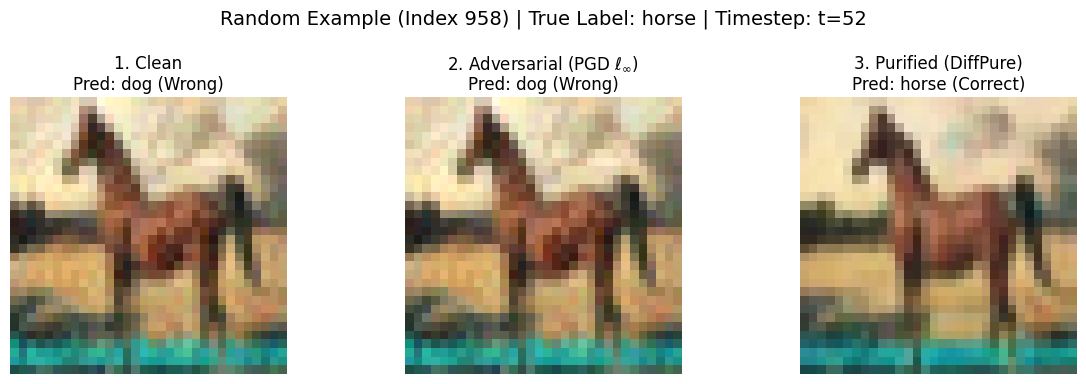

In [19]:
import matplotlib.pyplot as plt
import random

try:
    OPTIMAL_T = max(results, key=results.get)
except:
    OPTIMAL_T = 52
    print("Warning: 'results' dictionary was unavailable. Defaulting to PURIFICATION_TIMESTEP=52.")


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

random_index = random.randint(0, TEST_SUBSET_SIZE - 1)
print(f"\n--- Generating Random Example using Timestep t={OPTIMAL_T} (Index: {random_index}) ---")

clean_image_01 = test_images_subset[random_index:random_index+1].clone() # [1, 3, 32, 32]
adv_image_01 = test_images_subset[random_index:random_index+1].clone()  # PGD image is the adversarial input

true_label = test_labels_subset[random_index:random_index+1].clone()

purified_image_01 = purify_image(adv_image_01, diffusion_model_wrapper, OPTIMAL_T)

with torch.no_grad():
    # Normalization (Crucial step)
    normalized_clean = normalize_cifar10(clean_image_01)
    normalized_adv = normalize_cifar10(adv_image_01)
    normalized_purified = normalize_cifar10(purified_image_01)
    
    _, pred_clean = torch.max(baseline_model_for_attack(normalized_clean).data, 1)
    _, pred_adv = torch.max(baseline_model_for_attack(normalized_adv).data, 1)
    _, pred_purified = torch.max(baseline_model_for_attack(normalized_purified).data, 1)

true_label_name = classes[true_label.item()]
clean_pred_name = classes[pred_clean.item()]
adv_pred_name = classes[pred_adv.item()]
purified_pred_name = classes[pred_purified.item()]

clean_status = "Correct" if pred_clean.item() == true_label.item() else "Wrong"
adv_status = "Correct" if pred_adv.item() == true_label.item() else "Wrong"
purified_status = "Correct" if pred_purified.item() == true_label.item() else "Wrong"

clean_plot = clean_image_01.squeeze().permute(1, 2, 0).cpu().numpy()
adv_plot = adv_image_01.squeeze().permute(1, 2, 0).cpu().numpy()
purified_plot = purified_image_01.squeeze().permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(f"Random Example (Index {random_index}) | True Label: {true_label_name} | Timestep: t={OPTIMAL_T}", fontsize=14)

# Clean
axes[0].imshow(clean_plot)
axes[0].set_title(f"1. Clean\nPred: {clean_pred_name} ({clean_status})")
axes[0].axis('off')

# Adversarial
axes[1].imshow(adv_plot)
axes[1].set_title(f"2. Adversarial (PGD $\ell_\infty$)\nPred: {adv_pred_name} ({adv_status})")
axes[1].axis('off')

# Purified
axes[2].imshow(purified_plot)
axes[2].set_title(f"3. Purified (DiffPure)\nPred: {purified_pred_name} ({purified_status})")
axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()